In [28]:
# Libraries and configuration that will be used in this blog post
import datetime
from datetime import date
import os
import warnings

#import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
#import rasterio as rio
import contextily as cx
import folium
import configparser

# Set working directory
os.chdir(os.path.join('E:/',
                      'McKinley'))

warnings.filterwarnings('ignore')

In [30]:
# Restore datasets
# Seeding unit NDVI metrics
%store -r su_ndvi_annual_change_df

# Seeding unit data
%store -r mckinley_seeding_subset

# Met data
%store -r met_data_mckinley_df_annual

# Tracking the healing of a scarred landscape...
***How can we use remote sensing and weather data to monitor vegetation restoration at a disused coal mine in New Mexico?***

## Restoring vegetation communities back to health
The global economy has massive demands for resources that have to be extracted from the earth such as minerals, metals, aggregates, and hydrocarbons. The process of extracting these resources has an inevitable impact on local environments including damage, destruction, or loss of ecosystems and habitats. When resource projects close it is critical that vegetation ecosystems are restored to their pre-development or a better condition. This includes restoring the natural vegetation state and rebuilding the soils of disturbed lands through either natural processes (plant succession) or man-made rewilding/reseeding efforts. The responsible closure and restoration of natural ecosystems is fundamental to improving the sustainability of geological resource extraction projects.

<img src="img/environmental.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Fig 1 - Examples of the physical environmental impact of geological resource extraction. Left: Kennecott copper mine in Utah (Source: Kennecott). Right: Kern River oil field in Calfornia (Source: Sierra Club)</center>

## Using satellite imagery to track the pulse of vegetation recovery
The success of vegetation restoration efforts requires careful monitoring over many years to ensure that minimum thresholds are met with regards to vegetation cover, species makeup, function, and the health of the vegetation ecosystem. With the help of Nayani Ilangakoon (CU EarthLab) and Steve Perkins (Chevron) I have been exploring how we can use satellite imagery and weather data to monitor the success of vegetation restoration measures at McKinley Mine, a closed open pit coal mine, in north-western New Mexico (see map and figure below). 

In [ ]:
# Plot showing location map of McKinley Mine
# Import polygon for extent of location map
mckinley_aoi_large_path = os.path.join(
    'vectors', 'mckinley_large_figure_bounds.shp')
mckinley_aoi_large = gpd.read_file(mckinley_aoi_large_path)

# Import point polygon for McKinley Mine location
mckinley_location_path = os.path.join(
    'vectors', 'mckinley_location.shp')
mckinley_location = gpd.read_file(mckinley_location_path)

# Plot location map
fig, (ax) = plt.subplots(1, 1, figsize=(15, 10))

xlim = ([mckinley_aoi_large.total_bounds[0],
         mckinley_aoi_large.total_bounds[2]])
ylim = ([mckinley_aoi_large.total_bounds[1],
         mckinley_aoi_large.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

mckinley_location.plot(ax=ax,
                       color='red',
                       marker='*',
                       markersize=1000,
                       linewidth=2
                       )

cx.add_basemap(ax, crs=mckinley_aoi_large.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "Location map of McKinley Mine, NM (red star)", fontsize=20)

ax.set_axis_off()

<img src="img/restoration.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Fig 2 - Left: McKinley Mine open-pit coal mining operations. Right: the same location after reclamation and vegetation restoration</center>

For this work I used historical satellite imagery from the [Landsat 8 system](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con) going back to 2013 to explore how NDVI (Normalized Difference Vegetation Index), a common measure of the health or 'greenness' of vegetation that can be derived from the Landsat 8 data, changes over time for different areas of the mine, which have been revegetated at different times and using different approaches. I used as the basis for my analysis a database of 'seeding units' that provides information on the location/extent, age, and type of vegetation restoration that has been performed at McKinley Mine (see map below).

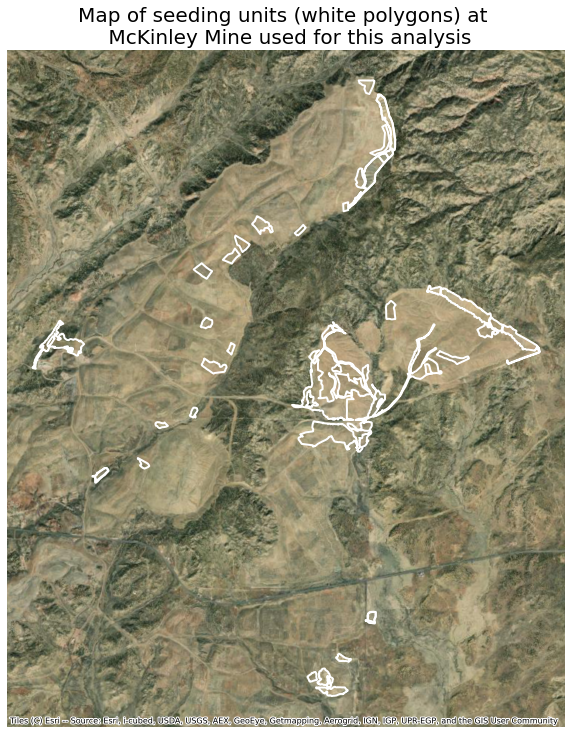

In [10]:
# Plot of seeding units
# Restore filtered seeding unit datasets
%store -r mckinley_seeding_subset_PARlo

# Plot the filtered seeding units
fig, (ax) = plt.subplots(1, 1, figsize=(10, 15))
mckinley_seeding_subset_PARlo.plot(ax=ax,
                                   color='None',
                                   edgecolor='white',
                                   linewidth=2)

cx.add_basemap(ax, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax.set_title(
    "Map of seeding units (white polygons) at \n McKinley Mine used for this analysis", fontsize=20)

ax.set_axis_off()

I built a [workflow](https://github.com/haselwimmer/vegetation-restoration-monitoring) to automate the extraction of the average NDVI values of the different seeding units from each of the Landsat 8 images; in total after removing satellite images with cloud and snow there were a total of 70 images from 2013 to 2021. The extracted 'time series' of NDVI values (see examples below) for the different seeding units stimulated a variety of questions that I hoped to answer:
1. How does NDVI vary with time for the different seeding units?
2. How does NDVI vary over the short and long-terms?
3. How does the type of seeding impact NDVI?
4. What is the impact of rainfall on the NDVI trends for the seeding units?

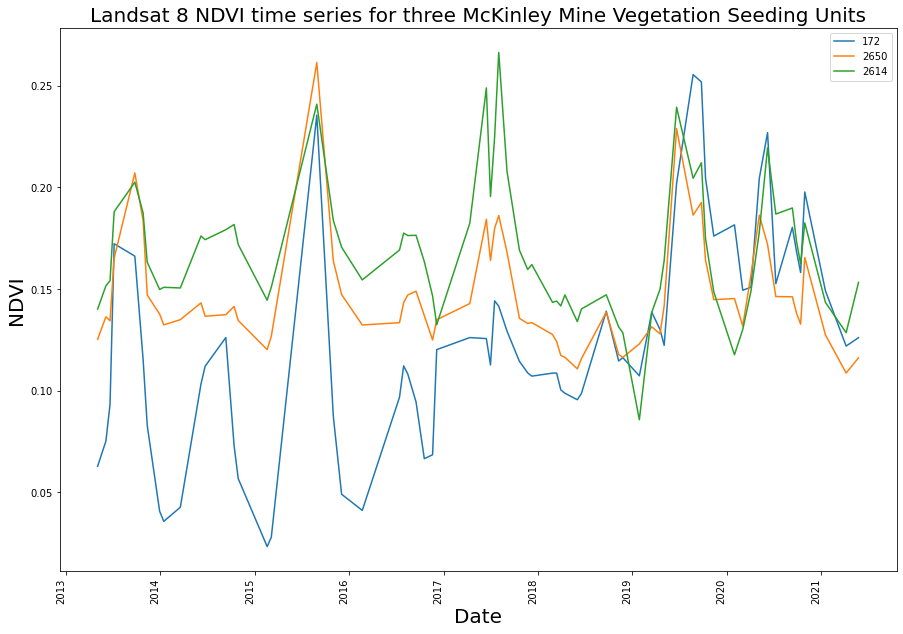

In [11]:
# Create plot for NDVI for seeding units
# Open the saved DF
%store -r landsat_8_time_series

# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique seeding units for legend
seeding_units = [172, 2650, 2614]

# Subset data to just one seeding unit
landsat_8_time_series = landsat_8_time_series[(landsat_8_time_series['SuId'] == 172)
                                              | (landsat_8_time_series['SuId'] == 2650)
                                              | (landsat_8_time_series['SuId'] == 2614)]

landsat_8_time_series.reset_index().groupby(
    'SuId').plot(x='date', y='MeanNdvi', ax=ax)

# Legend and labels
plt.legend(seeding_units)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Landsat 8 NDVI time series for three McKinley Mine Vegetation Seeding Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

## Investigating the short and long term trends in NDVI
When we look at the plot above we can see for each year that there is typically a peak in NDVI in the spring timeframe. This corresponds to the 'green-up' of vegetation, particularly annual and perennial grasses and flowering plants, that occurs in the spring followed by drying-out and browning (senescence) of the vegetation into the summer and fall. When you compare the maximum NVDI value against total precipitation (from gridMET) for each year there does seem to be a loose relationship in that the NDVI values are higher in wetter years. This is not unexpected but the relationship is not as strong as I would expect and perhaps points to other factors being important such as temperature and whether precipitation is in the form of snow or rain.

In [15]:
# Plot of annual max NDVI vs precipitation
title = "Annual Max NDVI vs precipitation for all seeding units"
fig = px.scatter(su_ndvi_annual_change_df,
                 x='precip', y='NDVI_max',
                 labels={
                     "NDVI_max": "Max NDVI",
                     "precip": "Precipitation (mm)"
},
    title=title,
    width=900, height=700,
    hover_name="SuId", hover_data=["NDVI_delta", "Year"],
    trendline="ols")

# Credit
fig.add_annotation(text="Source: Landsat 8 data from USGS, meteorological data from gridMET",
                   showarrow=False,
                   xref="paper", yref="paper",
                   x=0.01, y=0.01)

fig.update_layout(showlegend=False)
fig.show()

To better discern the long-term trends in NDVI I used an approach called a 'moving window' to smooth out the strong month to month variation. This technique worked by calculating an average NDVI across a two year period and shifting this period from month to month across the time series. The plot below shows an example of applying this algorithm to the time series for a single seeding unit. 

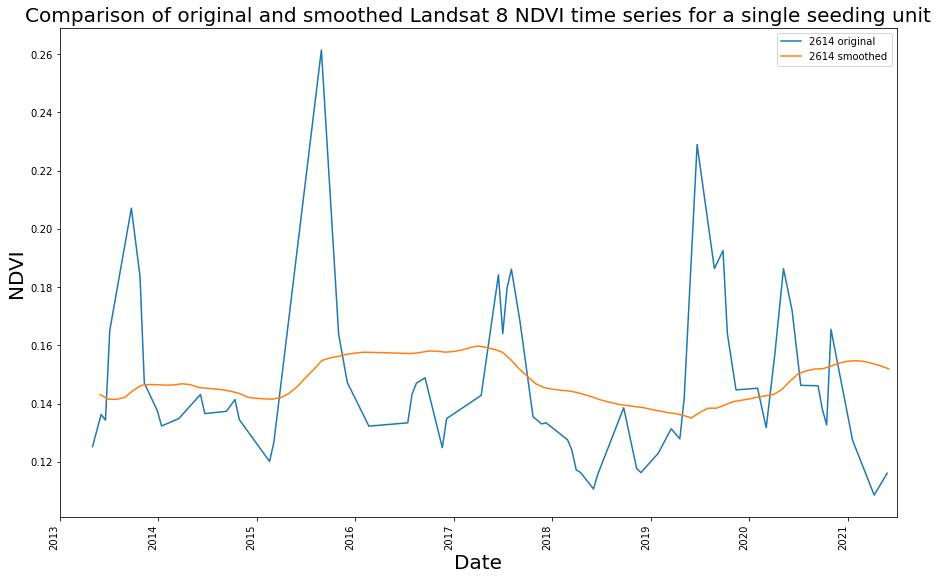

In [19]:
# Plot original and smoothed curves for one SuId on a single plot
fig, ax = plt.subplots(figsize=(15, 10))

suid = 2614

# Build list of unique seeding units for legend
seeding_units = ['2614 original', '2614 smoothed']

# Plot the original curve
landsat_8_time_series = landsat_8_time_series[(landsat_8_time_series['SuId'] == suid)]

landsat_8_time_series.reset_index().groupby(
    'SuId').plot(x='date', y='MeanNdvi', ax=ax)

# Plot the 2 year smoothed curve
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.reset_index()
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.set_index('date')
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean[(landsat_8_time_series_rlmean['SuId'] == suid)]

landsat_8_time_series_rlmean.groupby(
    'SuId').plot(y='MeanNdvi', ax=ax, use_index=True)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)
plt.xlim([datetime.date(2013,1,1), datetime.date(2021,6,29)])

ax.set_title(
    "Comparison of original and smoothed Landsat 8 NDVI time series for a single seeding unit", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.legend(seeding_units)
plt.show()

I investigated the significance of the age and type of vegetation restoration measure using various summary metrics that I calculated from the smoothed NDVI time series data. In particular I calculated an 'NDVI anomaly' that represented the difference in average NDVI between year 0 (when the seeding unit was restored) and subsequent years. The plot below shows for each seeding unit how the NDVI anomaly changes with time and also what type of restoration was performed. 

In general the plot below shows that post-restoration a majority of the seeding units have a positive and persistent NDVI anomaly consistent with the growth of new vegetation. That said there are seeding units where we see a reduction in the NDVI anomaly with time. Also, when we look at the type of restoration measure the plot does seem to indicate that seeding units that have been 're-seeded' do appear to have NDVI anomalies that are consistently trending down with the age. This is particularly interesting as these areas may indicate ongoing issues; re-seeding occurs with areas where restoration end-points are not being met and the revegetation has to start from scratch.

In [24]:
fig = px.scatter(su_ndvi_annual_change_df, x='Intervention_Year', y='NDVI_anomaly',
                 labels={
                     "NDVI_anomaly": "Smoothed NDVI anomaly",
                     "Intervention_Year": "Year"
                 },
                 title='NDVI anomaly vs age of seeding unit',
                 width=900, height=700,
                 hover_name="SuId", 
                 hover_data=["NDVI_anomaly", "Year"],
                 color="Seed_Type")

fig.update_traces(marker={'size': 10})

for suid, data in su_ndvi_annual_change_df.sort_values('Intervention_Year', ascending=True).groupby('SuId'):

    fig.add_trace(
        go.Scatter(
            x=data['Intervention_Year'],
            y=data['NDVI_anomaly'],
            mode="lines",
            line=go.scatter.Line(color="gray", width= 1),
            showlegend=False)
    )

# Credit
fig.add_annotation(text="Source: Landsat 8 data from USGS",
                   showarrow=False,
                   xref="paper", yref="paper",
                   x=0.01, y=0.01)

fig.update_layout(showlegend=True)
fig.show()

I also wanted to investigate whether there was any relationship between NDVI anomaly and annual precipitation for the seeding units. The plot below suggests that there isn't a relationship as we don't see higher NDVI anomalies in wetter years.

In [26]:
fig = px.scatter(su_ndvi_annual_change_df, x='precip', y='NDVI_anomaly',
                 labels={
                     "NDVI_anomaly": "Smoothed NDVI anomaly",
                     "precip": "Precipitation (mm)"
                 },
                 title='NDVI anomaly vs annual precipitation for the seeding units',
                 width=900, height=700,
                 hover_name="SuId", 
                 hover_data=["NDVI_anomaly", "Year"],
                 #size="precip",
                 color="Seed_Type")

# Credit
fig.add_annotation(text="Source: Landsat 8 data from USGS, meteorological data from gridMET",
                   showarrow=False,
                   xref="paper", yref="paper",
                   x=0.01, y=0.01)

fig.update_layout(showlegend=True)
fig.show()

## Identifying areas of concern
Using a simple threshold of the NDVI anomaly we can identify and map seeding units that may be of concern with regards to meeting vegetation restoration end points. In the figures below I have plotted maps of seeding units that have negative NDVI anomaly values (red) after three and five years respectively; seeding units that have positive values are indicated in green. What is particularly interesting is that the area towards the East of the map seems to show growing areas of concern between the two years. These may be areas that require follow-up with regards to the success of vegetation restoration.

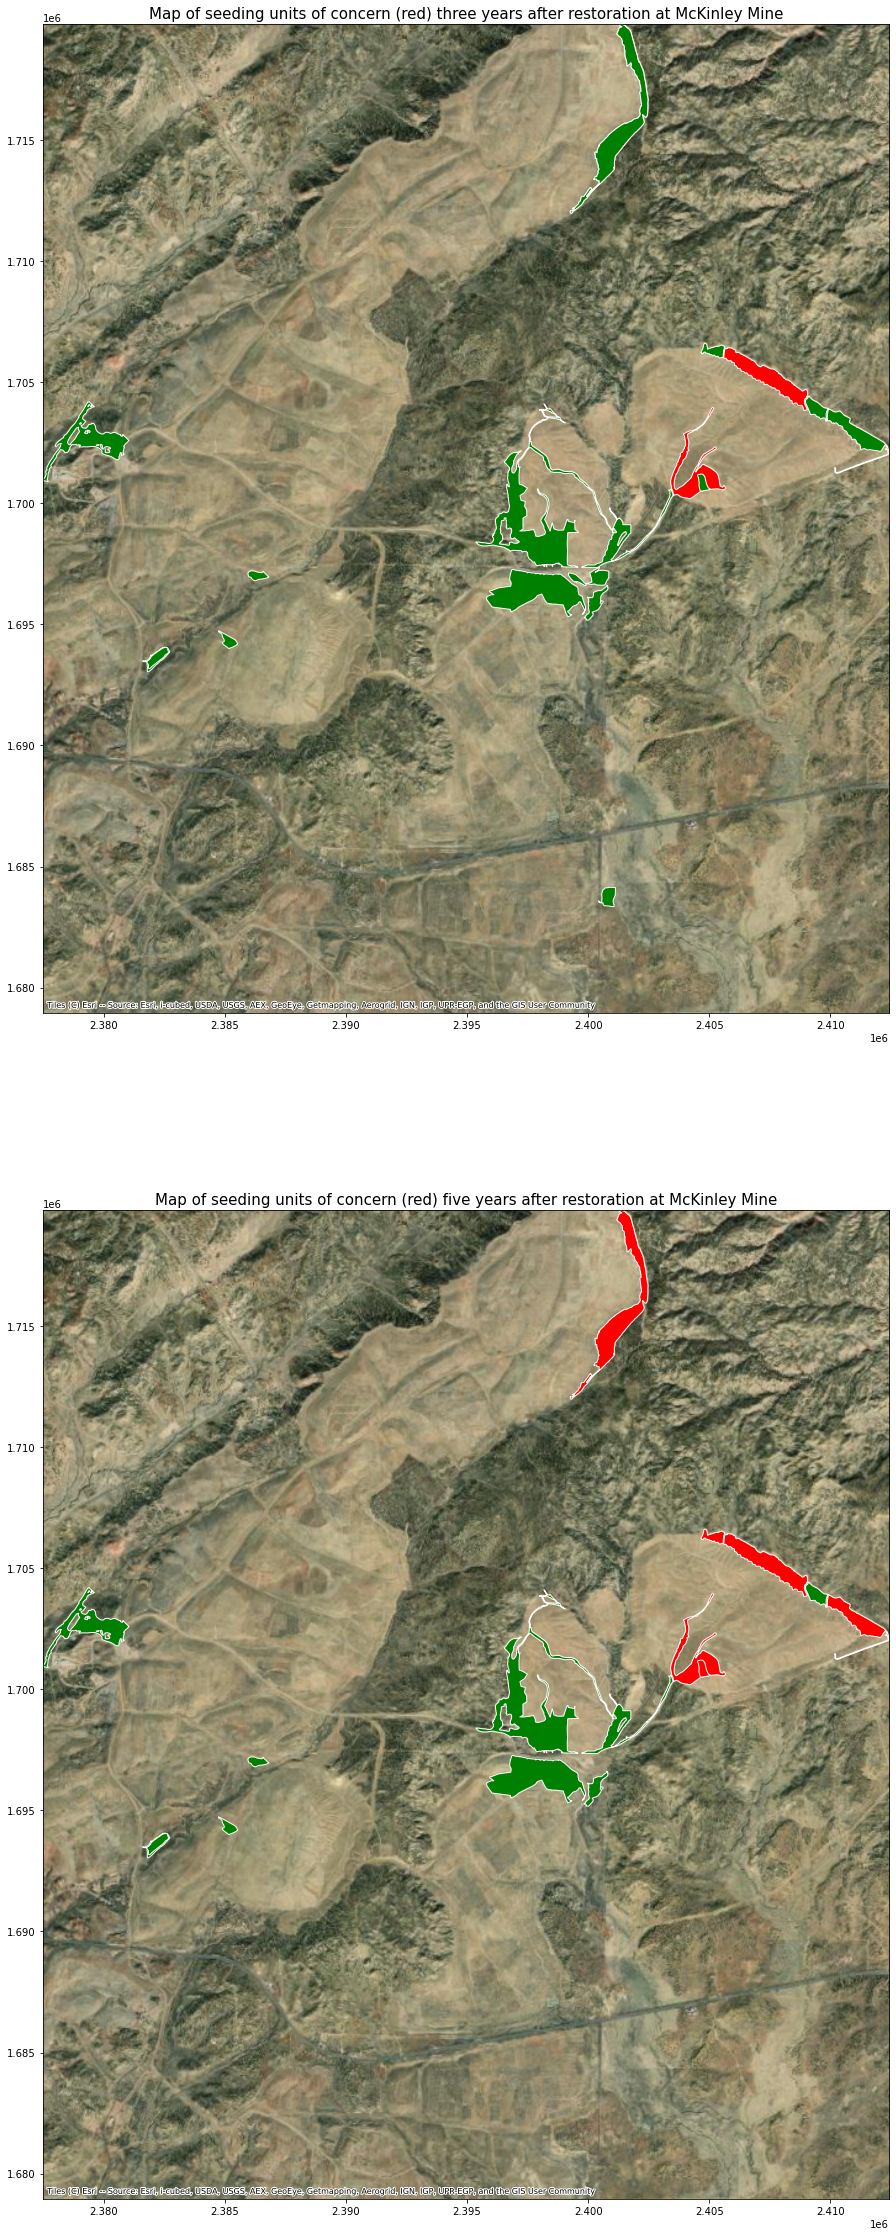

In [32]:
# Convert the df to a gdf
su_ndvi_annual_change_gdf = GeoDataFrame(
    su_ndvi_annual_change_df, geometry=su_ndvi_annual_change_df.geometry)

# Plot the filtered seeding units
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 40))

# Set the bounds
xlim = ([su_ndvi_annual_change_gdf.total_bounds[0],  su_ndvi_annual_change_gdf.total_bounds[2]])
ylim = ([su_ndvi_annual_change_gdf.total_bounds[1],  su_ndvi_annual_change_gdf.total_bounds[3]])

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

# Plot the su of concern
su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 3) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] <= 0)].plot(ax=ax1, color='Red', edgecolor='white', linewidth=1)

su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 3) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] >= 0)].plot(ax=ax1, color='Green', edgecolor='white', linewidth=1)

cx.add_basemap(ax1, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax1.set_title(
    "Map of seeding units of concern (red) three years after restoration at McKinley Mine", fontsize=15)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# Plot the su of concern
su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 5) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] <= 0)].plot(ax=ax2, color='Red', edgecolor='white', linewidth=1)

su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 5) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] >= 0)].plot(ax=ax2, color='Green', edgecolor='white', linewidth=1)

cx.add_basemap(ax2, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax2.set_title(
    "Map of seeding units of concern (red) five years after restoration at McKinley Mine", fontsize=15)

fig.show()

## Outcomes
This project has developed a framework for analyzing time series of satellite imagery for the purposes of monitoring the trajectory of vegetation restoration measures at McKinley Mine. The workflow allows the monitoring of the long-term trends in NDVI that may provide an indication of the success of vegetation restoration measures and identification of areas of concern. Comparison of the remote sensing trends with the seeding unit and rainfall data provide some interesting initial observations including of qualitatively lower NDVI values for areas categorized as 're-seeded' but do require further analysis.

Overall, I feel like this project has probably just scratched the surface when it comes to understanding how we can use remote sensing, geospatial, and meteorological data for monitoring vegetation restoration measures. There are a number of caveats to the work performed thus far as well as interesting opportunities for future research and development, for example:
1. This project has focused exclusivly on using NDVI that may be useful for monitoring grasses and flowering plants but may not be so sensitive to plants like shrubs that are a critical component of the final restored ecosystem. I am interested to explore what other remote sensing metrics/approaches could be used that may better capture the growth histories of grasses, flowering plants, and shrubs.
2. This project only used rainfall data but it would be interesting to also analyse other meteorological data such as temperature and type of precipitation (snow, rain).
3. To make the workflow truly beneficial to decision makers it will be important to compare/calibrate the results with ground-truth data.

## Resources
GitHub repo is available here: https://github.com/haselwimmer/vegetation-restoration-monitoring